In [1]:
%matplotlib widget 
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

import csv
import time
import scipy
import h5py
import astropy
import math
import corner as triangle

import os
import sys
os.environ["SPS_HOME"] = "/Users/zgl12/Modules/fsps/"  # adjust to your FSPS path

import matplotlib.ticker as mticker
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import WMAP9

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 2.

In [2]:
import fsps
import sedpy
from sedpy.observate import load_filters

import prospect
from prospect.models.transforms import tage_from_tuniv
from prospect.models import priors
from prospect.models.sedmodel import SedModel
from prospect.models.templates import TemplateLibrary
from prospect.models.sedmodel import PolySedModel, PolySpecModel
from prospect.models import transforms

from prospect.utils.obsutils import fix_obs

from prospect.plotting.utils import sample_posterior
from prospect.plotting.sfh import nonpar_mwa

from prospect.sources import FastStepBasis
from prospect.sources import CSPSpecBasis

from prospect.io.read_results import results_from, get_sps
import prospect.io.read_results as reader
from prospect.io.read_results import traceplot, subcorner

from prospect.utils.plotting import quantile

from scipy.special import gamma, gammainc
from scipy.stats import truncnorm
from scipy.signal import savgol_filter

/Users/zgl12/anaconda3/lib/python3.11/site-packages/sedpy/observate.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename, resource_listdir


In [3]:
file = '2019vxm_global.h5'
res, obs, mod = results_from(file, dangerous=False)

In [4]:
def build_model(obs=None, **extras):
    """prospector-alpha"""
    fit_order = [
        "zred",
        "logmass",
        "logzsol",
        "logsfr_ratios",
        "dust2",
        "dust_index",
        "dust1_fraction",
        "log_fagn",
        "log_agn_tau",
        "duste_qpah",
        "duste_umin",
        "log_duste_gamma",
        "gas_logz",
    ]

    # -------------
    # MODEL_PARAMS
    model_params = {}

    # --- BASIC PARAMETERS ---
    model_params["zred"] = {
        "N": 1,
        "isfree": True,
        "init": 0.5,
        "prior": priors.FastUniform(a=0.0, b=1.5 + 1e-3) 
    } 

    model_params["logmass"] = {
        "N": 1,
        "isfree": True,
        "init": 8.0,
        "units": "Msun",
        "prior": priors.FastUniform(a=6.0, b=12.0),
    }

    model_params["logzsol"] = {
        "N": 1,
        "isfree": True,
        "init": -0.5,
        "units": r"$\log (Z/Z_\odot)$",
        "prior": priors.FastUniform(a=-1.98, b=0.19),
    }

    model_params["imf_type"] = {
        "N": 1,
        "isfree": False,
        "init": 1,  # 1 = chabrier
        "units": None,
        "prior": None,
    }
    model_params["add_igm_absorption"] = {"N": 1, "isfree": False, "init": True}
    model_params["add_agb_dust_model"] = {"N": 1, "isfree": False, "init": True}
    model_params["pmetals"] = {"N": 1, "isfree": False, "init": -99}

    # --- SFH ---
    nbins_sfh = 7
    model_params["sfh"] = {"N": 1, "isfree": False, "init": 3}
    model_params["logsfr_ratios"] = {
        "N": 6,
        "isfree": True,
        "init": 0.0,
        "prior": priors.FastTruncatedEvenStudentTFreeDeg2(
            hw=np.ones(6) * 5.0, sig=np.ones(6) * 0.3
        ),
    }

    # add redshift scaling to agebins, such that
    # t_max = t_univ
    def zred_to_agebins(zred=None, **extras):
        amin = 7.1295
        nbins_sfh = 7
        tuniv = cosmo.age(zred)[0].value * 1e9
        tbinmax = tuniv * 0.9
        if zred <= 3.0:
            agelims = (
                [0.0, 7.47712]
                + np.linspace(8.0, np.log10(tbinmax), nbins_sfh - 2).tolist()
                + [np.log10(tuniv)]
            )
        else:
            agelims = np.linspace(amin, np.log10(tbinmax), nbins_sfh).tolist() + [
                np.log10(tuniv)
            ]
            agelims[0] = 0

        agebins = np.array([agelims[:-1], agelims[1:]])
        return agebins.T

    def logsfr_ratios_to_masses(
        logmass=None, logsfr_ratios=None, agebins=None, **extras
    ):
        """This converts from an array of log_10(SFR_j / SFR_{j+1}) and a value of
        log10(\Sum_i M_i) to values of M_i.  j=0 is the most recent bin in lookback
        time.
        """
        nbins = agebins.shape[0]
        sratios = 10 ** np.clip(logsfr_ratios, -100, 100)
        dt = 10 ** agebins[:, 1] - 10 ** agebins[:, 0]
        coeffs = np.array(
            [
                (1.0 / np.prod(sratios[:i]))
                * (np.prod(dt[1 : i + 1]) / np.prod(dt[:i]))
                for i in range(nbins)
            ]
        )
        m1 = (10**logmass) / coeffs.sum()

        return m1 * coeffs

    model_params["mass"] = {
        "N": 7,
        "isfree": False,
        "init": 1e6,
        "units": r"M$_\odot$",
        "depends_on": logsfr_ratios_to_masses,
    }

    model_params["agebins"] = {
        "N": 7,
        "isfree": False,
        "init": zred_to_agebins(np.atleast_1d(0.5)),
        "prior": None,
        "depends_on": zred_to_agebins,
    }

    # --- Dust Absorption ---
    model_params["dust_type"] = {
        "N": 1,
        "isfree": False,
        "init": 4,
        "units": "FSPS index",
    }
    model_params["dust1_fraction"] = {
        "N": 1,
        "isfree": True,
        "init": 1.0,
        "prior": priors.FastTruncatedNormal(a=0.0, b=2.0, mu=1.0, sig=0.3),
    }

    model_params["dust2"] = {
        "N": 1,
        "isfree": True,
        "init": 0.0,
        "units": "",
        "prior": priors.FastTruncatedNormal(a=0.0, b=4.0, mu=0.3, sig=1.0),
    }

    def to_dust1(dust1_fraction=None, dust1=None, dust2=None, **extras):
        return dust1_fraction * dust2

    model_params["dust1"] = {
        "N": 1,
        "isfree": False,
        "depends_on": to_dust1,
        "init": 0.0,
        "units": "optical depth towards young stars",
        "prior": None,
    }
    model_params["dust_index"] = {
        "N": 1,
        "isfree": True,
        "init": 0.7,
        "units": "",
        "prior": priors.FastUniform(a=-1.0, b=0.2),
    }

    # --- Nebular Emission ---
    model_params['nebemlineinspec'] = {"N": 1, "isfree": False, "init": False}
    #model_params["add_neb_emission"] = {"N": 1, "isfree": False, "init": True}
    #model_params["add_neb_continuum"] = {"N": 1, "isfree": False, "init": True}
    model_params["gas_logz"] = {
        "N": 1,
        "isfree": True,
        "init": 0.0,
        "units": r"log Z/Z_\odot",
        "prior": priors.FastUniform(a=-2.0, b=0.5),
    }
    model_params["gas_logu"] = {
        "N": 1,
        "isfree": False,
        "init": -1.0,
        "units": r"Q_H/N_H",
        "prior": priors.FastUniform(a=-4, b=-1),
    }

    # --- AGN dust ---
    model_params["add_agn_dust"] = {"N": 1, "isfree": False, "init": True}

    model_params["log_fagn"] = {
        "N": 1,
        "isfree": True,
        "init": -7.0e-5,
        "prior": priors.FastUniform(a=-5.0, b=-4.9),
    }

    def to_fagn(log_fagn=None, **extras):
        return 10**log_fagn

    model_params["fagn"] = {"N": 1, "isfree": False, "init": 0, "depends_on": to_fagn}

    model_params["log_agn_tau"] = {
        "N": 1,
        "isfree": True,
        "init": np.log10(20.0),
        "prior": priors.FastUniform(a=np.log10(15.0), b=np.log10(15.1)),
    }

    def to_agn_tau(log_agn_tau=None, **extras):
        return 10**log_agn_tau

    model_params["agn_tau"] = {
        "N": 1,
        "isfree": False,
        "init": 0,
        "depends_on": to_agn_tau,
    }

    # --- Dust Emission ---
    model_params["duste_qpah"] = {
        "N": 1,
        "isfree": True,
        "init": 2.0,
        "prior": priors.FastTruncatedNormal(a=0.9, b=1.1, mu=2.0, sig=2.0),
    }

    model_params["duste_umin"] = {
        "N": 1,
        "isfree": True,
        "init": 1.0,
        "prior": priors.FastTruncatedNormal(a=0.9, b=1.1, mu=1.0, sig=10.0),
    }

    model_params["log_duste_gamma"] = {
        "N": 1,
        "isfree": True,
        "init": -2.0,
        "prior": priors.FastTruncatedNormal(a=-2.1, b=-1.9, mu=-2.0, sig=1.0),
    }

    def to_duste_gamma(log_duste_gamma=None, **extras):
        return 10**log_duste_gamma

    model_params["duste_gamma"] = {
        "N": 1,
        "isfree": False,
        "init": 0,
        "depends_on": to_duste_gamma,
    }

    # ---- Units ----
    model_params["peraa"] = {"N": 1, "isfree": False, "init": False}

    model_params["mass_units"] = {"N": 1, "isfree": False, "init": "mformed"}

    tparams = {}
    for i in fit_order:
        tparams[i] = model_params[i]
    for i in list(model_params.keys()):
        if i not in fit_order:
            tparams[i] = model_params[i]
    model_params = tparams

    return PolySpecModel(model_params)


def build_sps(zcontinuous=2, compute_vega_mags=False, **extras):
    sps = FastStepBasis(zcontinuous=zcontinuous, compute_vega_mags=compute_vega_mags)
    return sps


def build_noise(**extras):
    return None, None


def scale(mass):
    upper_84 = np.interp(mass, massmet[:, 0], massmet[:, 3])
    lower_16 = np.interp(mass, massmet[:, 0], massmet[:, 2])
    return upper_84 - lower_16


def loc(mass):
    return np.interp(mass, massmet[:, 0], massmet[:, 1])

In [5]:
run_params = {}
mod = build_model(**run_params)
sps = build_sps(**run_params)

# Plot SED

In [6]:
def get_best_fit_SED(resultpars, obs, model, stellarpop):
    
    maggies = obs['maggies']
    maggies_unc = obs['maggies_unc']
    obs_filters = obs['filters']
    phot_obs_wave = obs['phot_wave']
    zred = obs['redshift']
    
    
    for i in range(2500):
        theta = resultpars["chain"][np.random.choice(np.arange(np.shape(resultpars["chain"])[0])), :]
        if obs["redshift"] != None:
            theta[0] = obs["redshift"]            
    
        if i == 0:
            best_spec, best_phot, mfrac = model.predict(theta, obs=obs, sps=stellarpop)
    
            best_phot_store = best_phot[:]
            best_spec_store = best_spec[:]
            mfrac_store = []
            theta_zred = []
        else:
            best_spec_single, best_phot_single, mfrac_single = model.predict(theta, obs=obs, sps=stellarpop)
    
            # iteratively update the mean
            best_spec = (best_spec * i + best_spec_single) / (i + 1)
            best_phot = (best_phot * i + best_phot_single) / (i + 1)
            mfrac = (mfrac * i + mfrac_single) / (i + 1)
            mfrac_store.append(mfrac)
            theta_zred.append(theta[0])
            best_phot_store = np.vstack([best_phot_store, best_phot_single])
            best_spec_store = np.vstack([best_spec_store, best_spec_single])
    
    best_phot = np.median(best_phot_store, axis=0)
    best_spec = np.median(best_spec_store, axis=0)
    best_mfrac = np.median(mfrac_store)
    mod_zred = np.median(theta_zred)
    phot_16, phot_84 = np.percentile(best_phot_store, [16, 84], axis=0)
    spec_16, spec_84 = np.percentile(best_spec_store, [16, 84], axis=0)
    
    
    filternames = [filter.name for filter in obs["filters"]]
    obs["filters"] = sedpy.observate.load_filters(filternames)
    rest_wavelength = stellarpop.wavelengths.copy()



    model_SED_dict = {
        'best_spec': best_spec,
        'spec_16': spec_16,
        'spec_84': spec_84,
        'best_phot': best_phot,
        'phot_16': phot_16,
        'phot_84': phot_84,
        'obs_phot': maggies,
        'obs_phot_unc': maggies_unc,
        'obs_filters': obs_filters,
        'phot_wave': phot_obs_wave,
        'obs_redshift': zred,
        'rest_spec_wavelengths': rest_wavelength,
        'mfrac': best_mfrac,
        'mod_zred': mod_zred
    }

    print('Found best fit model SED.')

    return model_SED_dict


In [7]:
model_dict = get_best_fit_SED(res, obs, mod, sps)

Found best fit model SED.


In [8]:
flux_obs = np.array(model_dict['obs_phot']) * 3631e6  # mu-Jy
flux_obs_unc = np.array(model_dict['obs_phot_unc']) * 3631e6  #mu-Jy

if model_dict['obs_redshift'] != None:
    zred = model_dict['obs_redshift']
else:
    zred = model_dict['mod_zred']
observed_wavelength = np.array(model_dict['rest_spec_wavelengths']) * (1+zred)

phot_wave = np.array(model_dict['phot_wave'])

best_spec = np.array(model_dict['best_spec']) * 3631e6
spec_16 = np.array(model_dict['spec_16']) * 3631e6
spec_84 = np.array(model_dict['spec_84']) * 3631e6
best_phot = np.array(model_dict['best_phot']) * 3631e6

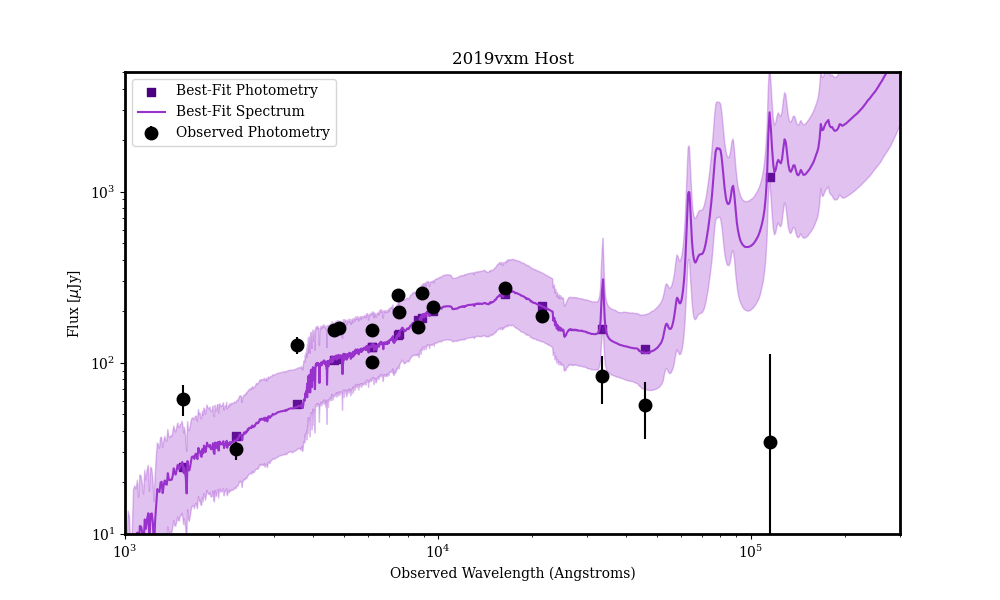

In [9]:
# Set the x-axis to logarithmic scale and label it in Angstroms
# Convert maggies to flux for plotting
plt.figure(figsize=(10, 6))

# Plot observed data points with error bars using rest_wavelength in Angstroms
plt.errorbar(
    phot_wave,  
    flux_obs,
    yerr=flux_obs_unc,
    fmt="o",
    ms = 9,
    color="black",
    label="Observed Photometry",
)



plt.scatter(phot_wave, best_phot, color="indigo", marker = 's', label="Best-Fit Photometry")

# Plot best-fit spectrum if available
plt.plot(observed_wavelength,best_spec,
        color="darkorchid",
        label="Best-Fit Spectrum",
        linestyle="-")


# Plot best-fit spectrum if available
plt.fill_between(observed_wavelength,spec_16,spec_84,
        color="darkorchid",
        linestyle="-", alpha=0.3)


plt.xscale("log")
plt.yscale("log")
plt.xlabel("Observed Wavelength (Angstroms)")
plt.ylabel("Flux [$\mu$Jy]")
#plt.grid(which="both", linestyle="--", linewidth=0.5)
plt.title(f"2019vxm Host")
#plt.xlim(1e3,3e5)
#plt.ylim(1e-2, 1e7)
plt.xlim(1e3,3e5)
plt.ylim(1e1,5e3)
plt.legend(loc='upper left')


plt.show()

In [10]:
np.array(res['theta_labels'], dtype='U20')


array(['zred', 'logmass', 'logzsol', 'logsfr_ratios_1', 'logsfr_ratios_2',
       'logsfr_ratios_3', 'logsfr_ratios_4', 'logsfr_ratios_5',
       'logsfr_ratios_6', 'dust2', 'dust_index', 'dust1_fraction',
       'log_fagn', 'log_agn_tau', 'duste_qpah', 'duste_umin',
       'log_duste_gamma'], dtype='<U20')

# Corner Plot

In [11]:
def zred_to_agebins(zred=None, nbins_sfh=7):
    tuniv = cosmo.age(zred).value[0]*1e9
    tbinmax = (tuniv*0.9)
    agelims = [0.0,7.4772] + np.linspace(8.0,np.log10(tbinmax),nbins_sfh-2).tolist() + [np.log10(tuniv)]
    agebins = np.array([agelims[:-1], agelims[1:]])
    return agebins.T


def resample_chain(resultpars, model_SED_dict, ncalc=100000):
    samples = resultpars['chain']
    xx = samples.copy()
    wghts = resultpars.get('weights', None)
    
    # logify some parameters
    xx = samples.copy()

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=ncalc)
    parnames = np.array(resultpars['theta_labels'], dtype='U20')

    mass_formed = theta_samp[:,parnames.tolist().index('logmass')]
    mfrac = model_SED_dict["mfrac"]
    surviving_mass = []
    for m in mass_formed:
        surviving_mass.append(m + np.log10(mfrac))

    surviving_mass = np.array(surviving_mass)

    dust1_frac = theta_samp[:,parnames.tolist().index('dust1_fraction')]
    dust2 = theta_samp[:,parnames.tolist().index('dust2')]

    dust = (dust1_frac*dust2 + dust2)*1.086
    
    logzsol = theta_samp[:,parnames.tolist().index('logzsol')]
    log_fagn = theta_samp[:,parnames.tolist().index('log_fagn')]
    log_agn_tau = theta_samp[:,parnames.tolist().index('log_agn_tau')]

    return surviving_mass, dust, logzsol, log_fagn, log_agn_tau



def get_mwa(agebins, sfr):
    ages = 10**agebins
    dt = np.abs(ages[:, 1] - ages[:, 0])
    return np.sum(np.mean(ages, axis=1) * sfr * dt) / np.sum(sfr * dt) / 1e9  # in Gyr


def get_MWA_and_SFH(resultpars, model_SED_dict, ncalc=100000):
    """
    Currently only works when nbins_SFH=7!
    """
    chain = resultpars["chain"]
    parnames = np.array(resultpars['theta_labels'])
    mfrac = model_SED_dict["mfrac"]
    
    npoints = chain.shape[0]
    sample_idx = np.random.choice(np.arange(npoints),size=ncalc,replace=True)
    thetas = chain[sample_idx,:]

    if model_SED_dict["obs_redshift"] is not None:
        zred = model_SED_dict["obs_redshift"]
    else:
        zred = model_SED_dict['mod_zred']

    nbins_sfh=7
    agebins = zred_to_agebins(zred=[zred],nbins_sfh=7)

    SFR = []
    sfr = np.zeros((ncalc, nbins_sfh)) # change to number of bins
            
    for i in range(ncalc): 
        sfr[i] = prospect.models.transforms.logsfr_ratios_to_sfrs(logmass=thetas[:, parnames.tolist().index('logmass')][i],
                                                                  logsfr_ratios=[thetas[:, parnames.tolist().index('logsfr_ratios_1')][i],
                                                                                 thetas[:, parnames.tolist().index('logsfr_ratios_2')][i],
                                                                                 thetas[:, parnames.tolist().index('logsfr_ratios_3')][i],
                                                                                 thetas[:, parnames.tolist().index('logsfr_ratios_4')][i],
                                                                                 thetas[:, parnames.tolist().index('logsfr_ratios_5')][i],
                                                                                 thetas[:, parnames.tolist().index('logsfr_ratios_6')][i]], 
                                                                  agebins=agebins)
        
        SFR.append(sfr[i])

    # Now we have a numpy array of the mass and SFR in each bin
    star_formation = [list(j) for j in SFR]
    npSFR = np.array(star_formation, dtype=float)
    MWA = []

    for p in npSFR:
        MWA.append(get_mwa(agebins, p))
    
    MWA_arr = np.array(MWA)

    # Calculate 100 Myr SFR
    SFR_100_Myr= np.median([npSFR[:,0],npSFR[:,1]], axis=0)


    return agebins, MWA_arr, npSFR, SFR_100_Myr



def star_formation_history(agebins, npSFR):
    nbins_sfh = 7
    t_lookback_log = [age[0] for age in agebins]
    t_lookback_log  = np.append(t_lookback_log, agebins[-1][-1]) # double last bin for plot purposes
    t_lookback_log[0]=0  # set age range for aesthetic purposes

    t_lookback  = (10**t_lookback_log)/1e9 # de-log agebins (in yr) and convert to Gyr


    #Calculate the quantiles
    Q16_SFR = [quantile(npSFR[:, i], percents=16, weights = None)
                 for i in range(nbins_sfh)]
             
    Q50_SFR = [quantile(npSFR[:, i], percents=50, weights = None)
                 for i in range(nbins_sfh)]

    Q84_SFR = [quantile(npSFR[:, i], percents=84, weights=None)
                 for i in range(nbins_sfh)]      


    # 16th percentile of SFR
    SFH_lower = np.insert(Q16_SFR, 0, Q16_SFR[0], axis=0)
    # 50th percentile of SFR
    SFH = np.insert(Q50_SFR, 0, Q50_SFR[0], axis=0)
    # 84th percentile of SFR
    SFH_upper = np.insert(Q84_SFR, 0, Q84_SFR[0], axis=0)


    return t_lookback, SFH, SFH_lower, SFH_upper

In [12]:
# Get chains
stellar_mass_chain, dust_AV_chain, logzsol_chain, log_fagn_chain, log_agn_tau_chain = resample_chain(res, model_dict, ncalc=100000)
agebins, MWA_chain, npSFR_chain, SFR_100_Myr_chain = get_MWA_and_SFH(res, model_dict, ncalc=100000)
# Get SFH
t_lookback, SFH, SFH_lower, SFH_upper = star_formation_history(agebins, npSFR_chain)

In [13]:
dust_AV_chain

array([0.4411194 , 0.5093784 , 0.49993494, ..., 0.5977028 , 0.63465065,
       1.0198747 ], dtype=float32)

In [ ]:
ssfr = np.log10(SFR_100_Myr_chain/(10**stellar_mass_chain))

In [ ]:
print(f"sSFR = {np.nanmedian(ssfr):.2f}^{np.nanpercentile(ssfr,84)-np.nanmedian(ssfr):.2f}_{np.nanmedian(ssfr)-np.nanpercentile(ssfr,16):.2f} [yr^-1]")

In [ ]:
np.nanpercentile(ssfr, [16,50,84])

In [14]:
# Save chains
model_dict['logzsol_chain'] = logzsol_chain
model_dict['log_fagn_chain'] = log_fagn_chain
model_dict['log_agn_tau_chain'] = log_agn_tau_chain
model_dict['dust_AV_chain'] = dust_AV_chain
model_dict['stellar_mass_chain'] = stellar_mass_chain
model_dict['MWA_chain'] = MWA_chain
model_dict['SFR_100_Myr_chain'] = SFR_100_Myr_chain
model_dict['zred_chain'] = np.ones(100000)*obs['redshift']
# Save SFH
model_dict['t_lookback_for_SFH'] = t_lookback
model_dict['SFH_median'] = SFH
model_dict['SFH_lower'] = SFH_lower
model_dict['SFH_upper'] = SFH_upper


In [15]:
def theta_corner(model_dict, **kwargs):
    
    # Get parameter names 
    zred = model_dict['zred_chain']
    logzsol = model_dict['logzsol_chain'] 
    agntau = model_dict['log_agn_tau_chain']
    logmass = model_dict['stellar_mass_chain']
    age = model_dict['MWA_chain']
    SFR = model_dict['SFR_100_Myr_chain']
    fagn = model_dict['log_fagn_chain']
    dust = model_dict['dust_AV_chain']

    if model_dict['obs_redshift'] is not None:
        new_theta = []
        for i in np.arange(0, len(logmass), 1):
            new_idx = [logmass[i], logzsol[i], age[i], dust[i], SFR[i], agntau[i], fagn[i]]
            new_theta.append(new_idx)
        new_theta = np.array(new_theta)
        param_latex = ['log($M_*/M_\odot$)', 'log($Z_*/Z_\odot$)', '$t_m$ [Gyr]', '$A_V$ [mag]', 'SFR', r'$\tau_{AGN}$', '$f_{AGN}$']

    else:
        new_theta = []
        for i in np.arange(0, len(logmass), 1):
            new_idx = [zred[i], logmass[i], logzsol[i], age[i], dust[i], SFR[i], agntau[i], fagn[i]]
            new_theta.append(new_idx)
        new_theta = np.array(new_theta)
        param_latex = ['z','log($M_*/M_\odot$)', 'log($Z_*/Z_\odot$)', '$t_m$ [Gyr]', '$A_V$ [mag]', 'SFR', r'$\tau_{AGN}$', '$f_{AGN}$']
    
    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(np.array(new_theta), weights=None, nsample=100000)

    # plot figure
    figure = triangle.corner(theta_samp, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkorchid', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    return figure

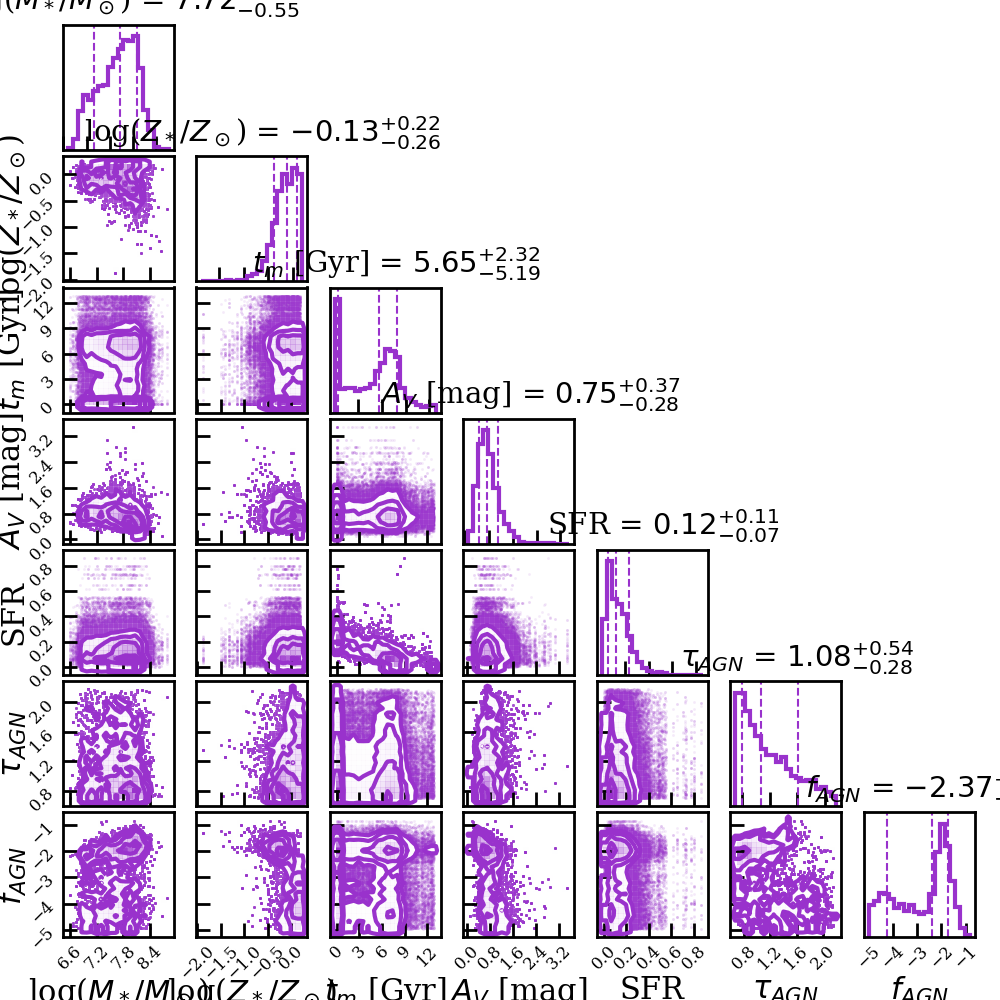

In [17]:
if model_dict['obs_redshift'] is not None:
    plot_dim = 7
else:
    plot_dim = 8

cornerfig = theta_corner(model_dict, fig=plt.subplots(plot_dim,plot_dim,figsize=(10,10))[0], 
                                      title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                                      label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
    
for ax in cornerfig.get_axes():
        ax.tick_params(axis='both', labelsize=12, length=10, width=2, direction='in')
    
plt.subplots_adjust(wspace=0.20, hspace=0.05)
plt.savefig('2019vxm_corner_sed.png', dpi=300, bbox_inches='tight')
plt.show()

The above shows stellar mass, stellar metallicity, mass-weighted stellar population age, host global dust extinction, present-day SFR, and two AGN parameters: MIR optical depth, and fraction of total host bolometric luminosity that comes from AGN (there is no AGN in this host)

# SFH

In [ ]:
fig = plt.figure(figsize=[10,10])

fig, ax = plt.subplots(figsize=[8,6])
plt.title(f'2019vxm Host Star Formation History', fontsize = 20)
plt.xlabel('t$_{lookback}$ (Gyr)', fontsize = 20)
plt.ylabel('SFR ($M_{\odot}$yr$^{-1}$)', fontsize = 20)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.minor.width'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 3
ax.tick_params(axis='x', which='minor')

t_lookback = model_dict['t_lookback_for_SFH']
SFH_lower = model_dict['SFH_lower']
SFH_upper = model_dict['SFH_upper']
SFH = model_dict['SFH_median']

# use step function to generate the SFH plot
plt.step(t_lookback, SFH_lower, alpha = 1, c = 'darkorchid', linewidth=3)
plt.step(t_lookback, SFH_upper, alpha = 1, c = 'darkorchid', linewidth=3)
plt.step(t_lookback, SFH, alpha = 1.0, c = 'darkorchid', linewidth=3)

# Since it's the lookback time, we want the x-axis limits to be flipped
plt.xlim(t_lookback[-1], 0.01) # setting max for aesthetic purposes
#plt.xscale('log')
plt.yscale('log')



for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=20, length=12, width=2, direction='in')
    ax.set_xscale('log')
    ax.set_xticks([0.01, 0.1, 1, 10])
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    #ax.xaxis.set_minor_formatter(mticker.ScalarFormatter(False))
    
    
    ax.yaxis.labelpad = -10

# shading the regions between 16th and 84th percentiles
plt.fill_between(t_lookback,SFH_lower,SFH_upper, where=None,interpolate=False,step='pre',color="thistle")

plt.show()

In [ ]:
# np.save('/Users/anyanugent/Documents/GitHub/frankenblast/data/sed_output/2019vxm/2019vxm_global.npy',model_dict)